# Applying Trained Higgs NN Model to New Data

This notebook demonstrates how to:
1. Load a pre-trained Neural Network (NN) model and scaler.
2. Load and preprocess new signal and background ROOT files (or other data sources).
3. Apply the trained model to make predictions on this new data.
4. Use a previously optimized NN output cut to select signal-like events.
5. Calculate the expected Signal (S), Background (B), and Significance (e.g., S/sqrt(B)).

## 1. Imports

In [10]:
import uproot
import pandas as pd
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import os
import glob
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Plotting style
plt.style.use('seaborn-v0_8-pastel')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

## 2. Configuration

In [11]:
# Paths to saved model and scaler (from Higgs_NN_SN_Optimization.ipynb)
notebook_base_dir = os.getcwd() # Assumes this notebook is in 'higgs_lovers'
model_path = os.path.join(notebook_base_dir, "higgs_nn_model_sn_opt.pkl")
scaler_path = os.path.join(notebook_base_dir, "higgs_nn_scaler_sn_opt.pkl")


# --- User Configuration for New Data ---
# Using the same data as in Higgs_NN_SN_Optimization.ipynb for demonstration
new_data_dir = os.path.join(notebook_base_dir, "data") 
new_signal_file_pattern = os.path.join(new_data_dir, "DAOD_PHYSLITE.38191712.*.pool.root.1")
new_background_file_path = os.path.join(new_data_dir, "DAOD_PHYSLITE.37110937._000011.pool.root.1")


# Tree name in your new ROOT files
new_tree_name = "CollectionTree"

# Branches to read for the new data. 
# These must allow you to reconstruct the 12 features the model was trained on.
branches_to_read_new_data = [
    "AnalysisElectronsAuxDyn.pt", "AnalysisElectronsAuxDyn.charge",
    "AnalysisMuonsAuxDyn.pt", "AnalysisMuonsAuxDyn.charge",
    "EventInfoAuxDyn.mcEventWeights", "EventInfoAuxDyn.PileupWeight_NOSYS"
]

# Optimized NN output cut from Higgs_NN_SN_Optimization.ipynb
optimized_nn_cut = 0.7227 # From previous notebook run (S/sqrt(B) max @ 0.7227)
print(f"Configuration loaded.")
print(f"Model path: {model_path}")
print(f"Scaler path: {scaler_path}")
print(f"New signal pattern: {new_signal_file_pattern}")
print(f"New background path: {new_background_file_path}")
print(f"Optimized NN cut: {optimized_nn_cut}")

Configuration loaded.
Model path: /Users/xin/Documents/Documents/College/Phys_392/higgs_lovers/higgs_nn_model_sn_opt.pkl
Scaler path: /Users/xin/Documents/Documents/College/Phys_392/higgs_lovers/higgs_nn_scaler_sn_opt.pkl
New signal pattern: /Users/xin/Documents/Documents/College/Phys_392/higgs_lovers/data/DAOD_PHYSLITE.38191712.*.pool.root.1
New background path: /Users/xin/Documents/Documents/College/Phys_392/higgs_lovers/data/DAOD_PHYSLITE.37110937._000011.pool.root.1
Optimized NN cut: 0.7227


## 3. Data Loading and Preprocessing Function for New Data

In [12]:
def load_and_preprocess_new_data(file_path, is_signal_flag, tree_name_param, branches_to_read_param):
    """
    Reads a ROOT file, extracts and processes data to match the required 12 lepton features,
    and returns a pandas DataFrame.
    This version is adapted from Higgs_NN_SN_Optimization.ipynb make_mini_df function.
    """
    try:
        tree = uproot.open(file_path)[tree_name_param]
    except Exception as e:
        print(f"Error opening file {file_path}: {e}")
        return pd.DataFrame()

    try:
        arr = tree.arrays(branches_to_read_param, library="ak")
    except Exception as e:
        print(f"Error reading branches from {file_path}: {e}")
        return pd.DataFrame()

    # Separate electrons and muons
    ele_pt = arr["AnalysisElectronsAuxDyn.pt"]
    ele_charge = arr["AnalysisElectronsAuxDyn.charge"]
    mu_pt = arr["AnalysisMuonsAuxDyn.pt"]
    mu_charge = arr["AnalysisMuonsAuxDyn.charge"]

    # Concatenate into one [n_events, n_leptons] array
    lep_pt = ak.concatenate([ele_pt, mu_pt], axis=1)
    lep_charge = ak.concatenate([ele_charge, mu_charge], axis=1)
    
    # Create a type array: 11 for electrons, 13 for muons
    lep_type = ak.concatenate([
        ak.full_like(ele_pt, 11),
        ak.full_like(mu_pt, 13)
    ], axis=1)

    # Keep only events with at least 4 leptons
    four_lepton_mask = ak.num(lep_pt) >= 4
    
    lep_pt = lep_pt[four_lepton_mask]
    lep_charge = lep_charge[four_lepton_mask]
    lep_type = lep_type[four_lepton_mask]
    
    if len(lep_pt) == 0:
        print(f"No events with >= 4 leptons in {file_path}")
        return pd.DataFrame()

    # Event weights
    mc_weights = arr["EventInfoAuxDyn.mcEventWeights"][four_lepton_mask]
    nominal_mc_weight = mc_weights[:, 0] if mc_weights.ndim > 1 else mc_weights
    pileup_weight = arr["EventInfoAuxDyn.PileupWeight_NOSYS"][four_lepton_mask]
    total_event_weight = nominal_mc_weight * pileup_weight

    # Construct the DataFrame with the 12 features
    df_dict = {
        "lep_pt_1": lep_pt[:, 0] / 1000.0, # MeV to GeV
        "lep_pt_2": lep_pt[:, 1] / 1000.0,
        "lep_pt_3": lep_pt[:, 2] / 1000.0,
        "lep_pt_4": lep_pt[:, 3] / 1000.0,
        "lep_charge_1": lep_charge[:, 0], "lep_charge_2": lep_charge[:, 1],
        "lep_charge_3": lep_charge[:, 2], "lep_charge_4": lep_charge[:, 3],
        "lep_type_1": lep_type[:, 0], "lep_type_2": lep_type[:, 1],
        "lep_type_3": lep_type[:, 2], "lep_type_4": lep_type[:, 3],
        "totalWeight": total_event_weight,
        "isSignal": is_signal_flag
    }
    df = pd.DataFrame(df_dict)
    
    # Apply physics-based pre-selections (same as in training)
    charge_sum_mask = (df["lep_charge_1"] + df["lep_charge_2"] + df["lep_charge_3"] + df["lep_charge_4"]) == 0
    df = df[charge_sum_mask]
    
    valid_lepton_type_sums = {44, 48, 52} # 4e, 2e2mu, 4mu
    type_sum = (df["lep_type_1"] + df["lep_type_2"] + df["lep_type_3"] + df["lep_type_4"])
    df = df[type_sum.isin(valid_lepton_type_sums)]
    
    return df

print("load_and_preprocess_new_data function defined and adapted.")

load_and_preprocess_new_data function defined and adapted.


## 4. Load New Signal and Background Data

In [13]:
# Load new signal files
new_signal_files = glob.glob(new_signal_file_pattern)
if not new_signal_files:
    print(f"No new signal files found matching pattern: {new_signal_file_pattern}")
    new_signal_df = pd.DataFrame()
else:
    print(f"Found {len(new_signal_files)} new signal files. Processing...")
    new_signal_dfs = [load_and_preprocess_new_data(f, 1, new_tree_name, branches_to_read_new_data) for f in new_signal_files]
    new_signal_df = pd.concat(new_signal_dfs, ignore_index=True)

print(f"New Signal DataFrame shape: {new_signal_df.shape}")

# Load new background file
if not os.path.exists(new_background_file_path):
    print(f"New background file not found: {new_background_file_path}")
    new_background_df = pd.DataFrame()
else:
    print(f"Processing new background file: {new_background_file_path}")
    new_background_df = load_and_preprocess_new_data(new_background_file_path, 0, new_tree_name, branches_to_read_new_data)
print(f"New Background DataFrame shape: {new_background_df.shape}")

# Combine new signal and background
if not new_signal_df.empty or not new_background_df.empty:
    new_combined_df = pd.concat([new_signal_df, new_background_df], ignore_index=True)
    print(f"New Combined DataFrame shape before dropna: {new_combined_df.shape}")
    print("New Combined DataFrame head:")
    print(new_combined_df.head())
    new_combined_df.dropna(inplace=True) # Basic cleaning
    print(f"New Combined DataFrame shape after dropna: {new_combined_df.shape}")
else:
    print("Both new signal and background DataFrames are empty. Cannot proceed.")
    new_combined_df = pd.DataFrame() # Ensure it's defined

Found 17 new signal files. Processing...
Error opening file /Users/xin/Documents/Documents/College/Phys_392/higgs_lovers/data/DAOD_PHYSLITE.38191712._000019.pool.root.1: expected Chunk of length 814,
received 0 bytes from FSSpecSource
for file path /Users/xin/Documents/Documents/College/Phys_392/higgs_lovers/data/DAOD_PHYSLITE.38191712._000019.pool.root.1
Error opening file /Users/xin/Documents/Documents/College/Phys_392/higgs_lovers/data/DAOD_PHYSLITE.38191712._000019.pool.root.1: expected Chunk of length 814,
received 0 bytes from FSSpecSource
for file path /Users/xin/Documents/Documents/College/Phys_392/higgs_lovers/data/DAOD_PHYSLITE.38191712._000019.pool.root.1
New Signal DataFrame shape: (614610, 14)
Processing new background file: /Users/xin/Documents/Documents/College/Phys_392/higgs_lovers/data/DAOD_PHYSLITE.37110937._000011.pool.root.1
New Signal DataFrame shape: (614610, 14)
Processing new background file: /Users/xin/Documents/Documents/College/Phys_392/higgs_lovers/data/DAOD

## 5. Load Trained Model and Scaler

In [14]:
try:
    loaded_model = joblib.load(model_path)
    loaded_scaler = joblib.load(scaler_path)
    print("Trained model and scaler loaded successfully.")
except FileNotFoundError:
    print(f"Error: Saved model ('{model_path}') or scaler ('{scaler_path}') not found.")
    print("Please ensure the paths are correct and the model training notebook has been run.")
    loaded_model = None
    loaded_scaler = None
except Exception as e:
    print(f"An error occurred while loading model/scaler: {e}")
    loaded_model = None
    loaded_scaler = None

Trained model and scaler loaded successfully.


## 6. Prepare Features from New Data and Make Predictions

In [15]:
if loaded_model and loaded_scaler and not new_combined_df.empty:
    # Define features list (must match training)
    features_list = [
        'lep_pt_1', 'lep_pt_2', 'lep_pt_3', 'lep_pt_4', 
        'lep_charge_1', 'lep_charge_2', 'lep_charge_3', 'lep_charge_4',
        'lep_type_1', 'lep_type_2', 'lep_type_3', 'lep_type_4'
    ]
    
    # Check if all required features are in the new_combined_df
    if all(feature in new_combined_df.columns for feature in features_list) and \
       'isSignal' in new_combined_df.columns and 'totalWeight' in new_combined_df.columns:
        
        X_new = new_combined_df[features_list].values
        y_new_true = new_combined_df["isSignal"] # True labels for the new data (if available)
        w_new = new_combined_df["totalWeight"]    # Weights for the new data

        # Scale the new data features
        X_new_scaled = loaded_scaler.transform(X_new)
        print(f"New data scaled. X_new_scaled shape: {X_new_scaled.shape}")

        # Make predictions (probabilities for the positive class, i.e., signal)
        y_new_pred_proba = loaded_model.predict_proba(X_new_scaled)[:, 1]
        print(f"Predictions made on new data. y_new_pred_proba shape: {y_new_pred_proba.shape}")
        
        # Display a few example predictions
        print("\nExample predictions (NN scores) for first 5 new events:")
        for i in range(min(5, len(y_new_pred_proba))):
            print(f"  Event {i}: True Label={y_new_true.iloc[i] if not y_new_true.empty else 'N/A'}, Weight={w_new.iloc[i]:.2f}, NN Score={y_new_pred_proba[i]:.4f}")
            
    else:
        print("Error: Not all required columns (features, isSignal, totalWeight) found in new_combined_df.")
        print(f"Required features: {features_list}")
        print(f"Available columns: {new_combined_df.columns.tolist()}")
        X_new_scaled = np.array([])
        y_new_pred_proba = np.array([])
        y_new_true = pd.Series()
        w_new = pd.Series()
        
elif new_combined_df.empty:
    print("New combined DataFrame is empty. Cannot make predictions.")
    X_new_scaled = np.array([])
    y_new_pred_proba = np.array([])
    y_new_true = pd.Series()
    w_new = pd.Series()
else:
    print("Model or scaler not loaded. Cannot make predictions.")
    X_new_scaled = np.array([])
    y_new_pred_proba = np.array([])
    y_new_true = pd.Series()
    w_new = pd.Series()

New data scaled. X_new_scaled shape: (637612, 12)
Predictions made on new data. y_new_pred_proba shape: (637612,)

Example predictions (NN scores) for first 5 new events:
  Event 0: True Label=1, Weight=32.96, NN Score=0.7602
  Event 1: True Label=1, Weight=29.74, NN Score=0.8443
  Event 2: True Label=1, Weight=20.81, NN Score=0.4121
  Event 3: True Label=1, Weight=28.41, NN Score=0.8478
  Event 4: True Label=1, Weight=29.18, NN Score=0.1582
Predictions made on new data. y_new_pred_proba shape: (637612,)

Example predictions (NN scores) for first 5 new events:
  Event 0: True Label=1, Weight=32.96, NN Score=0.7602
  Event 1: True Label=1, Weight=29.74, NN Score=0.8443
  Event 2: True Label=1, Weight=20.81, NN Score=0.4121
  Event 3: True Label=1, Weight=28.41, NN Score=0.8478
  Event 4: True Label=1, Weight=29.18, NN Score=0.1582


## 7. Apply Optimized Cut and Calculate S, B for New Data

In [16]:
if y_new_pred_proba.size > 0 and not y_new_true.empty and not w_new.empty:
    # Apply the optimized threshold to the NN output probabilities for the new data
    selected_new_signal_mask = (y_new_true == 1) & (y_new_pred_proba >= optimized_nn_cut)
    selected_new_background_mask = (y_new_true == 0) & (y_new_pred_proba >= optimized_nn_cut)

    # Calculate weighted sum of signal (S_new) and background (B_new) events in the new data
    S_final_new = np.sum(w_new[selected_new_signal_mask])
    B_final_new = np.sum(w_new[selected_new_background_mask])

    print(f"\nApplied cut NN > {optimized_nn_cut:.4f} to new data:")
    print(f"  Weighted Signal Events (S_new): {S_final_new:.2f}")
    print(f"  Weighted Background Events (B_new): {B_final_new:.2f}")
else:
    print("Cannot apply cut: Predictions, true labels, or weights for new data are not available or empty.")
    S_final_new = 0
    B_final_new = 0


Applied cut NN > 0.7227 to new data:
  Weighted Signal Events (S_new): 9751837.00
  Weighted Background Events (B_new): 56532512.00


## 8. Calculate Significance for New Data

In [17]:
if S_final_new > 0 or B_final_new > 0: # Proceed if there are any events after cut
    # S/sqrt(B) - Simple significance
    if B_final_new > 0:
        s_over_sqrt_b_new = S_final_new / np.sqrt(B_final_new)
        print(f"  S/sqrt(B) for new data: {s_over_sqrt_b_new:.2f}")
    else:
        s_over_sqrt_b_new = np.inf if S_final_new > 0 else 0
        print(f"  S/sqrt(B) for new data: {s_over_sqrt_b_new} (B_new is 0)")
    
    # S/B ratio
    if B_final_new > 0:
        s_over_b_new = S_final_new / B_final_new
        print(f"  S/B for new data: {s_over_b_new:.2f}")
    else:
        s_over_b_new = np.inf if S_final_new > 0 else 0
        print(f"  S/B for new data: {s_over_b_new} (B_new is 0)")
        
    # Asimov Significance (Z_A) - More advanced, often used in HEP
    # Z_A = sqrt(2 * ((S+B) * ln(1+S/B) - S))
    # This formula assumes B is well-known. For cases with uncertainty on B, more complex formulae are used.
    if S_final_new >= 0 and B_final_new > 0: # S must be non-negative
        try:
            asimov_significance = np.sqrt(2 * ((S_final_new + B_final_new) * np.log(1 + S_final_new / B_final_new) - S_final_new))
            print(f"  Asimov Significance (Z_A) for new data: {asimov_significance:.2f}")
        except Exception as e:
            print(f"  Could not calculate Asimov significance: {e}")
    elif S_final_new > 0 and B_final_new == 0:
        print("  Asimov Significance (Z_A) for new data: Inf (B_new is 0, S_new > 0)")
    else: # S_final_new is 0 or (S_final_new is 0 and B_final_new is 0)
        print("  Asimov Significance (Z_A) for new data: 0")
else:
    print("No signal or background events found after applying the cut to new data. Cannot calculate significance.")

  S/sqrt(B) for new data: 1296.99
  S/B for new data: 0.17
  Asimov Significance (Z_A) for new data: 1262.15


## 9. Visualization of NN Output on New Data (Optional)

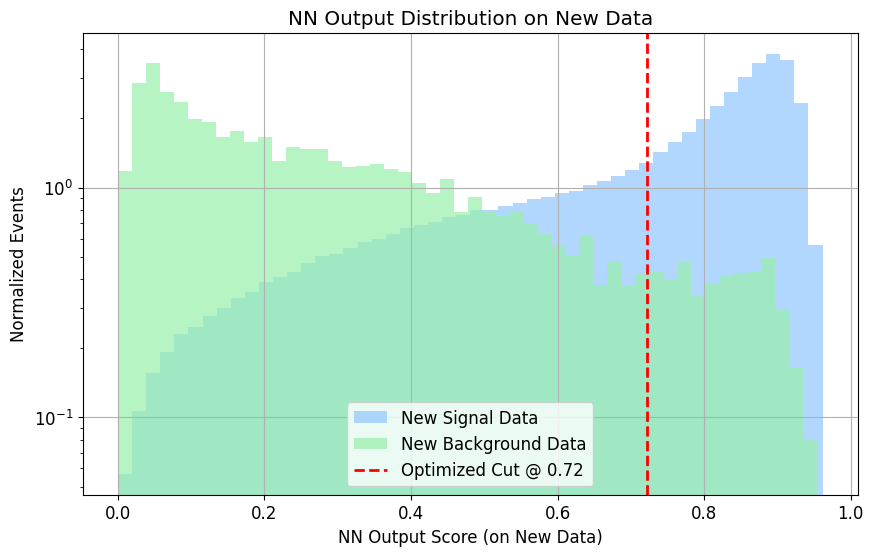

In [18]:
if y_new_pred_proba.size > 0 and not y_new_true.empty and not w_new.empty:
    plt.figure()
    # Plot NN output for new signal events
    plt.hist(y_new_pred_proba[y_new_true == 1], bins=50, weights=w_new[y_new_true == 1],
             label='New Signal Data', histtype='stepfilled', alpha=0.7, density=True)
    # Plot NN output for new background events
    plt.hist(y_new_pred_proba[y_new_true == 0], bins=50, weights=w_new[y_new_true == 0],
             label='New Background Data', histtype='stepfilled', alpha=0.7, density=True)
    
    plt.axvline(optimized_nn_cut, color='red', linestyle='--', lw=2,
                label=f'Optimized Cut @ {optimized_nn_cut:.2f}')

    plt.xlabel('NN Output Score (on New Data)')
    plt.ylabel('Normalized Events')
    plt.title('NN Output Distribution on New Data')
    plt.legend()
    plt.grid(True)
    plt.yscale('log') # Use log scale for y-axis if desired
    plt.show()
else:
    print("Cannot plot: Predictions, true labels, or weights for new data are not available or empty.")

## 10. Conclusion for New Data Application

This notebook section outlined the steps to apply the trained model. Key takeaways:
- The reusability of the model depends heavily on consistent feature engineering for new data.
- The optimized cut from the original dataset can be applied, but its performance should be re-evaluated on the new dataset if its characteristics differ significantly.
- Significance calculations provide a quantitative measure of the model's effectiveness in separating signal from background on the new data.